In [1]:
#.libPaths()

#had some issues with installing packages in jupyter notebook and this fixed all my problems
#.libPaths(R.home('/opt/homebrew/Caskroom/miniforge/base/lib/R/library'))

In [2]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1011. NC Well Metals/P1011.2. Analyses/P1011.2.4. Contamination Mapping/Output')
cur_date = "050125"

library(readxl)
library(tidyverse)
library(reshape2)
library(tigris)
library(geojsonio)
library(cowplot)

# reading in file
well_data = data.frame(read_excel("Input/Well_Data_011425.xlsx")) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


Attaching package: ‘geojsonio’


The following object is masked from ‘package:base’:

    pretty



Attaching package: ‘cowplot’


The following object is masked from ‘package:lub

In [3]:
head(well_data)

,Tax_ID,Health_Dept_ID,Permit_No,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Geology,⋯,Metal,Concentration,Detect_Concentration,DDLat,DDLon,objectid,GEOID,total_pop,st_areasha,st_perimet
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1006004,960,12-155,41176,52,165,41,60.0,7.7,Carolina Slate Belt - CZmd3,⋯,Ar,1.531414,ND,35.17970,-80.29918,14,37179020100,6266,223490506,77333.13
2,1024009,1803,15-177,42355,40,445,42,2.0,7.3,Carolina Slate Belt - CZfv2,⋯,Ar,2.348528,ND,35.15487,-80.31061,14,37179020100,6266,223490506,77333.13
3,1054019,1647,14-212,42037,45,160,40,40.0,7.4,Carolina Slate Belt - CZmd3,⋯,Ar,2.043848,ND,35.16158,-80.33170,14,37179020100,6266,223490506,77333.13
4,1057017,970,12-169,41204,42,440,57,1.5,8.0,Carolina Slate Belt - CZmd2,⋯,Ar,35.000000,D,35.13962,-80.32263,14,37179020100,6266,223490506,77333.13
5,1060006,533,10-239,40546,48,120,42,25.0,7.1,Carolina Slate Belt - CZmd2,⋯,Ar,2.297118,ND,35.13027,-80.32911,14,37179020100,6266,223490506,77333.13
6,1066006,1795,15-224,42353,60,280,32,10.0,8.2,Carolina Slate Belt - CZmd2,⋯,Ar,53.000000,D,35.10479,-80.32205,14,37179020100,6266,223490506,77333.13


Mapping arsenic and manganese concentrations across Union County, NC. 

In [4]:
# removing data we don't need and taking average per census tract
avg_df = well_data %>%
    filter(Metal != 'Cr') %>%
    group_by(Metal, GEOID) %>%
    summarize(Avg_Concentration = mean(Concentration))

head(avg_df)

`summarise()` has grouped output by 'Metal'. You can override using the
`.groups` argument.


Metal,GEOID,Avg_Concentration
<chr>,<dbl>,<dbl>
Ar,37179020100,18.720882
Ar,37179020202,27.408738
Ar,37179020203,4.107268
Ar,37179020204,14.353367
Ar,37179020305,1.222858
Ar,37179020306,37.000000


How many census tracts had concentrations above the MCL or HAL?

In [5]:
avg_df %>%
    filter(Metal == 'Ar', Avg_Concentration >= 10) %>%
    count()

avg_df %>%
    filter(Metal == 'Mn', Avg_Concentration >= 300) %>%
    count()

Metal,n
<chr>,<int>
Ar,14


Metal,n
<chr>,<int>
Mn,5


In [6]:
# download shapefile from the tigris (census package)
union_county_census_tracts = tracts(state = 37, county = 179, year = 2018) 

head(union_county_census_tracts)

  |======================================================================| 100%


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<MULTIPOLYGON [°]>
337,37,179,020901,37179020901,209.01,Census Tract 209.01,G5020,S,203506500,1753575,+34.8637965,-080.4247764,MULTIPOLYGON (((-80.54601 3...
338,37,179,020401,37179020401,204.01,Census Tract 204.01,G5020,S,28215452,359353,+35.0237736,-080.5546358,MULTIPOLYGON (((-80.60175 3...
339,37,179,020902,37179020902,209.02,Census Tract 209.02,G5020,S,137943408,2382720,+34.8477552,-080.6116346,MULTIPOLYGON (((-80.72832 3...
498,37,179,020800,37179020800,208,Census Tract 208,G5020,S,137993164,1498324,+34.9688372,-080.3330504,MULTIPOLYGON (((-80.42014 3...
499,37,179,020100,37179020100,201,Census Tract 201,G5020,S,222051078,1634224,+35.0964380,-080.3591790,MULTIPOLYGON (((-80.49615 3...
860,37,179,021010,37179021010,210.10,Census Tract 210.10,G5020,S,32929955,847103,+35.0217267,-080.7354087,MULTIPOLYGON (((-80.77367 3...


In [7]:
# changing some of the data types before joining files
avg_df$GEOID = as.character(avg_df$GEOID)

as_df = full_join(avg_df %>%
    filter(Metal == 'Ar'), union_county_census_tracts) %>%
    # creating a dichotomized concentration
    mutate(MCL = factor(ifelse(Avg_Concentration >= 10, "Greater Than", "Less Than"), levels = c('Less Than', 'Greater Than')))

mn_df = full_join(avg_df %>%
    filter(Metal == 'Mn'), union_county_census_tracts) %>%
    # creating a dichotomized concentration
    mutate(HAL = factor(ifelse(Avg_Concentration >= 300, "Greater Than", "Less Than"), levels = c('Less Than', 'Greater Than')))

head(as_df)

Joining with `by = join_by(GEOID)`
Joining with `by = join_by(GEOID)`


Metal,GEOID,Avg_Concentration,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,MCL
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<MULTIPOLYGON [°]>,<fct>
Ar,37179020100,18.720882,37,179,020100,201,Census Tract 201,G5020,S,222051078,1634224,+35.0964380,-080.3591790,MULTIPOLYGON (((-80.49615 3...,Greater Than
Ar,37179020202,27.408738,37,179,020202,202.02,Census Tract 202.02,G5020,S,79833282,523621,+35.0775080,-080.5344921,MULTIPOLYGON (((-80.59366 3...,Greater Than
Ar,37179020203,4.107268,37,179,020203,202.03,Census Tract 202.03,G5020,S,30940199,234482,+35.1743251,-080.5614853,MULTIPOLYGON (((-80.6283 35...,Less Than
Ar,37179020204,14.353367,37,179,020204,202.04,Census Tract 202.04,G5020,S,103655072,1264704,+35.1426575,-080.4951961,MULTIPOLYGON (((-80.60048 3...,Greater Than
Ar,37179020305,1.222858,37,179,020305,203.05,Census Tract 203.05,G5020,S,17487601,170902,+35.1013282,-080.5956357,MULTIPOLYGON (((-80.63251 3...,Less Than
Ar,37179020306,37.000000,37,179,020306,203.06,Census Tract 203.06,G5020,S,12396442,115023,+35.0679725,-080.6119632,MULTIPOLYGON (((-80.63651 3...,Greater Than


## As continuous concentrations

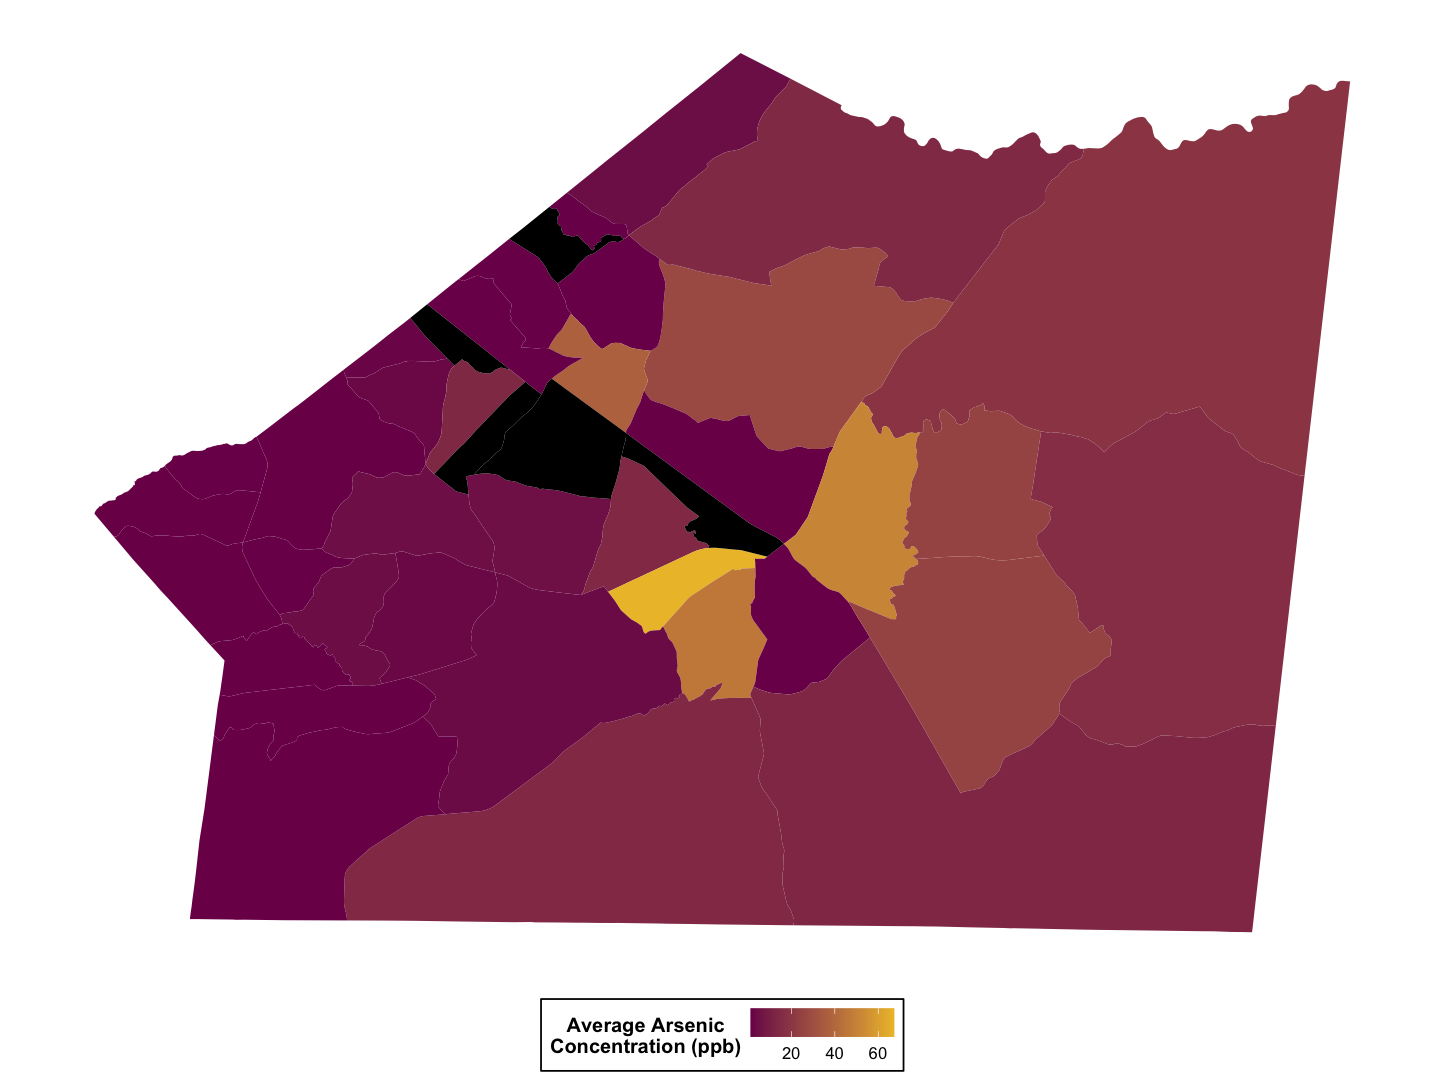

In [8]:
options(repr.plot.width = 12, repr.plot.height = 9) #changing size

Figure1a = ggplot() +
  geom_sf(data = as_df, aes(fill = Avg_Concentration, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.direction = "horizontal",
      legend.position = 'bottom',
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradient(low = "#7c1158",
      high = "#edbf33",
      na.value = "black",
      name = "   Average Arsenic\nConcentration (ppb)")

Figure1a

## As dichotomous concentrations

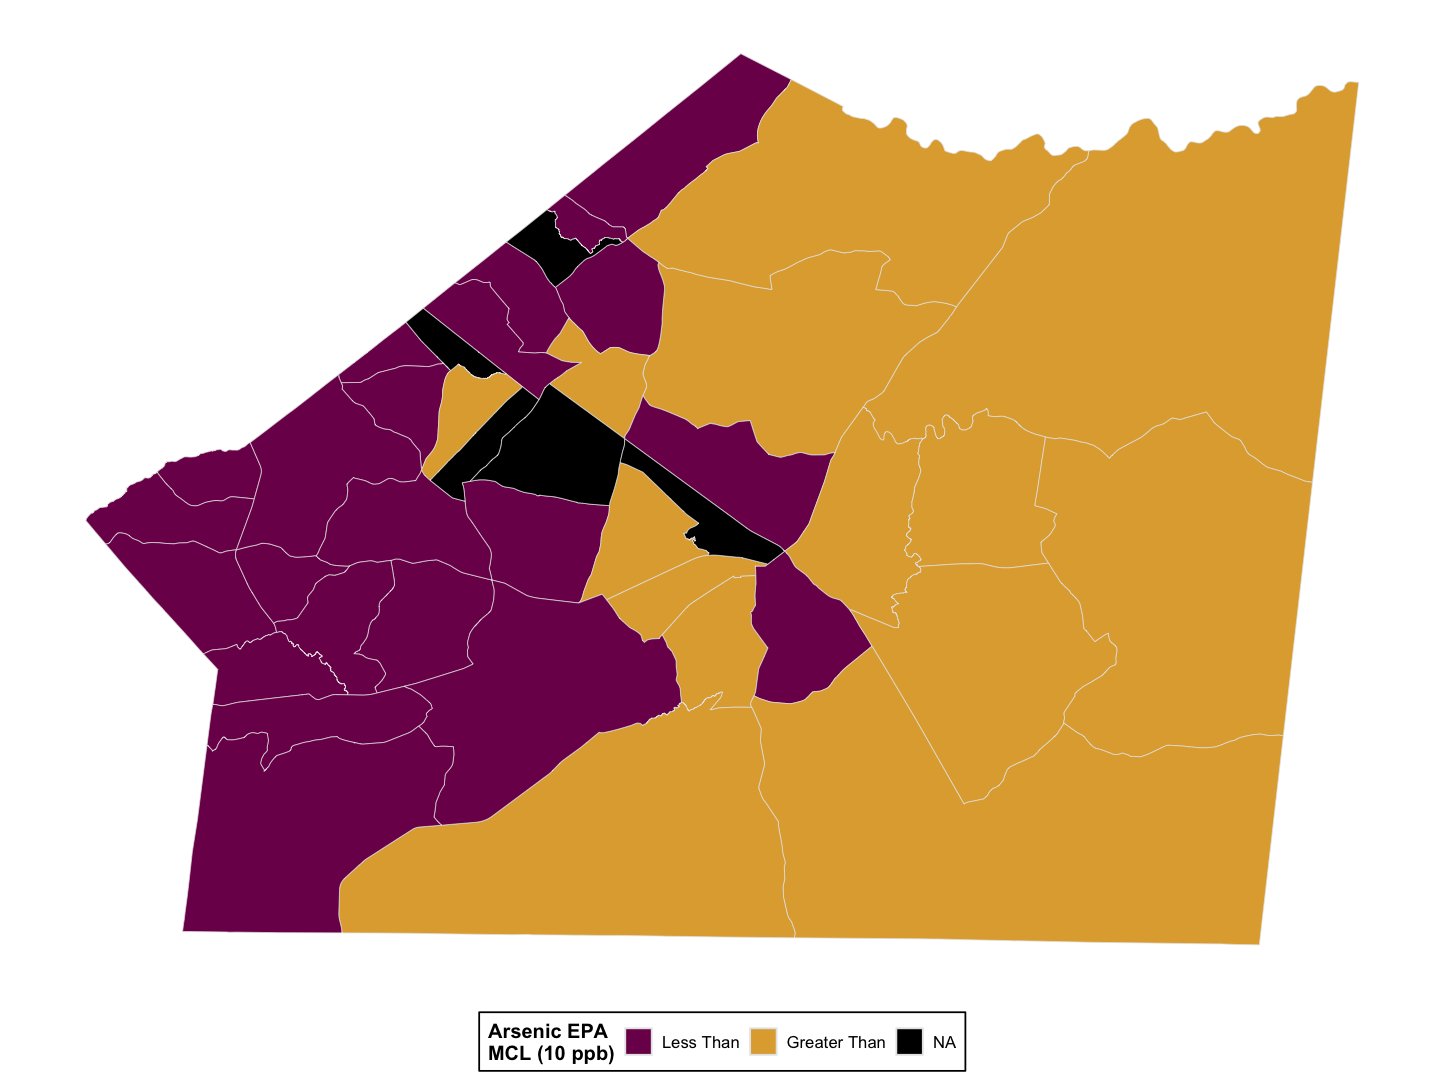

In [9]:
Figure1b = ggplot() +
  geom_sf(data = as_df, aes(fill = MCL, geometry = geometry), 
          color = 'gray90') + # changes color between census tracts

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.direction = "horizontal",
      legend.position = 'bottom',
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_manual(values = c("#7c1158", "#e0aa3e"), 
                    na.value = "black", # making geo ids w/ NA values black
                    name = "Arsenic EPA\nMCL (10 ppb)") 

Figure1b

## Mn continous concentrations

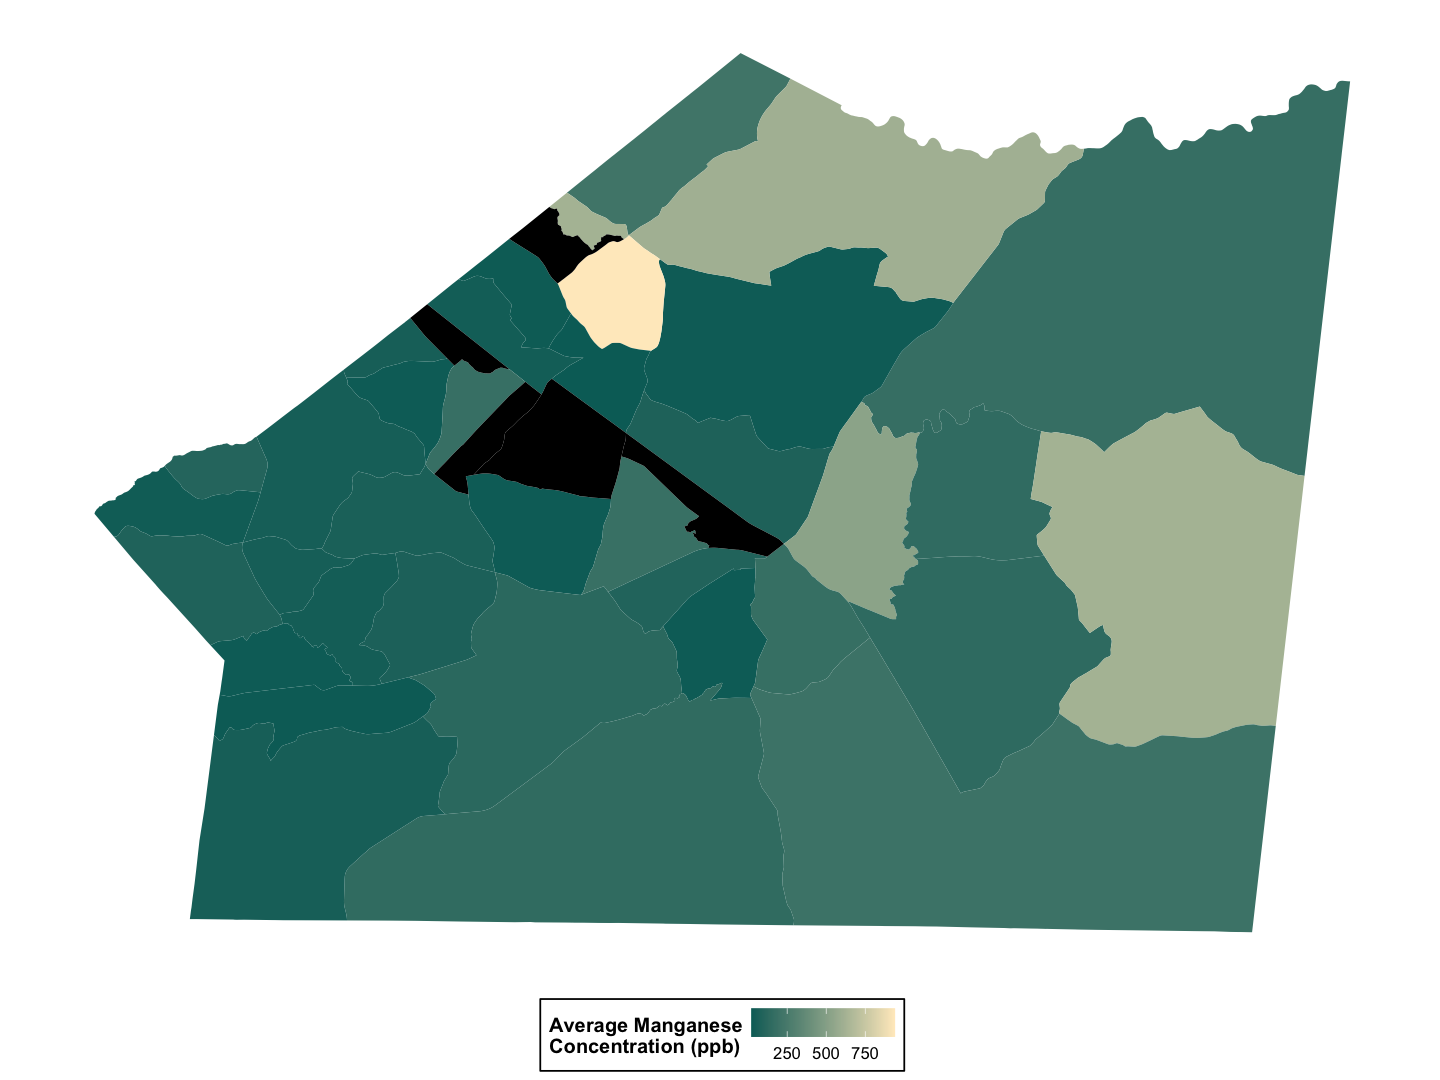

In [10]:
Figure1c = ggplot() +
  geom_sf(data = mn_df, aes(fill = Avg_Concentration, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.direction = "horizontal",
      legend.position = 'bottom',
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradient(low = "#006C67",
      high = "#FFEBC6",
      na.value = "black",
      name = "Average Manganese\nConcentration (ppb)")

Figure1c

## Mn dichotomous concentrations

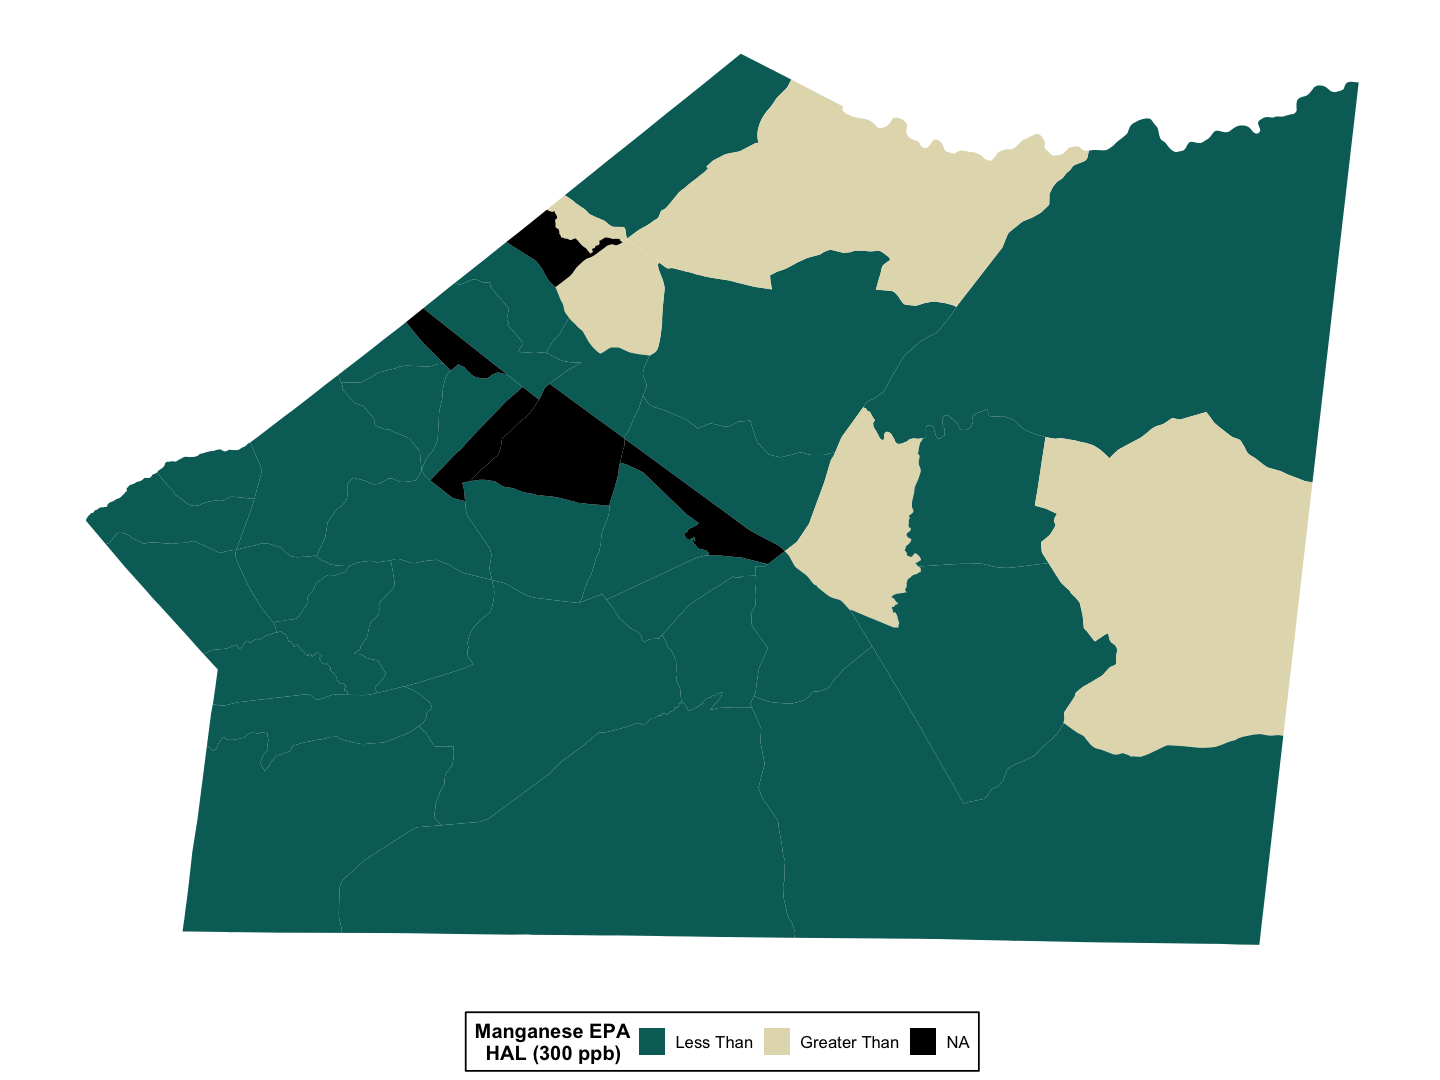

In [11]:
Figure1d = ggplot() +
  geom_sf(data = mn_df, aes(fill = HAL, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 12), # changes legend title
      legend.text = element_text(size = 10), # changes legend text
      legend.direction = "horizontal",
      legend.position = 'bottom',
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_manual(values = c("#006C67", "#e3dbba"), 
                    na.value = "black", # making geo ids w/ NA values black
                    name = "Manganese EPA\n  HAL (300 ppb)") 

Figure1d

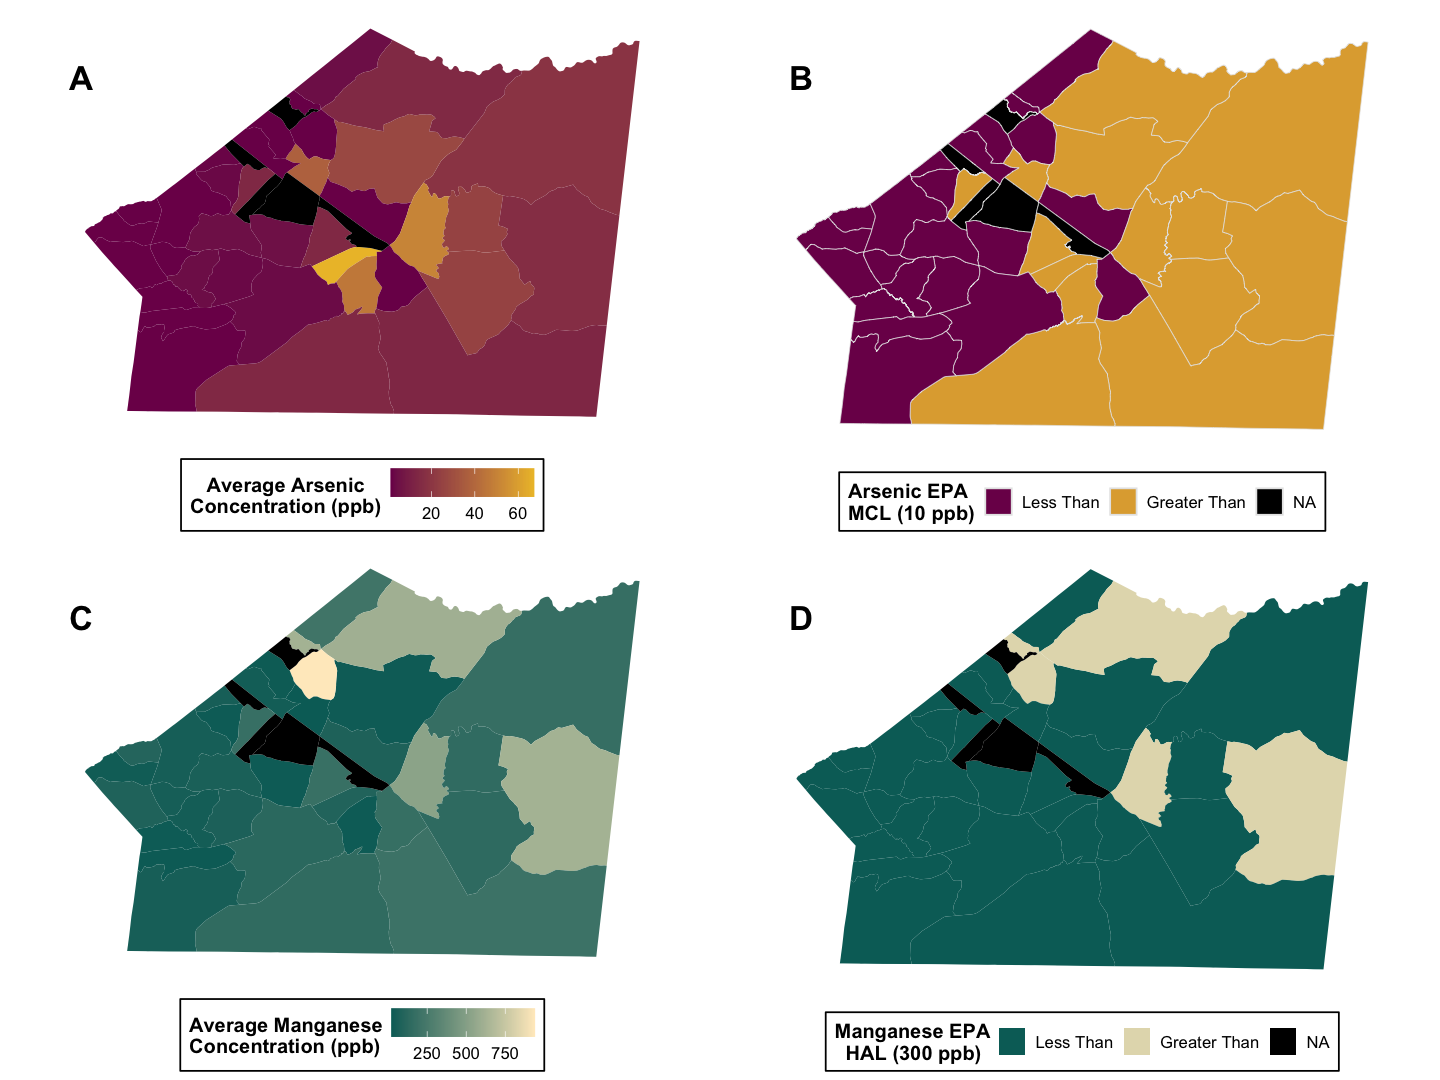

In [12]:
Figure1 = plot_grid(Figure1a, Figure1b, Figure1c, Figure1d,
                            # adding labels, changing size their size and position
                            labels = "AUTO", label_size = 20, label_x = 0.08, label_y = 0.9)
Figure1

In [13]:
# exporting figure
ggsave(Figure1, 
       filename = 'Figure 1.pdf',
       path = Output,
       # need to respecify dimensions here when exporting figures
       width = 12, height = 9)